In [1]:
!pip install pandas_datareader
!pip install tensorflow
!pip install yfinance

In [49]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from datetime import timedelta
import yfinance as yf
pd.options.mode.chained_assignment = None

In [3]:
acao = "MGLU3.SA"

yf.pdr_override()

inicio = "2014-12-31"
final = "2023-04-24"

dados_acao = pdr.get_data_yahoo(acao, start=inicio, end=final)

dados_acao

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,0.243750,0.243750,0.231562,0.232812,0.215259,6323200
2015-01-05,0.235625,0.240625,0.229687,0.237187,0.219304,10326400
2015-01-06,0.238437,0.238437,0.233125,0.234062,0.216414,12572800
2015-01-07,0.237500,0.242187,0.234687,0.241875,0.223638,6454400
2015-01-08,0.239375,0.242187,0.237500,0.240000,0.221905,8393600
...,...,...,...,...,...,...
2023-04-14,3.810000,3.850000,3.720000,3.740000,3.740000,89414800
2023-04-17,3.770000,3.770000,3.640000,3.660000,3.660000,89761000
2023-04-18,3.700000,3.730000,3.530000,3.540000,3.540000,108901600


In [4]:
# pegando valor do fechamento das cotações

cotacao = dados_acao["Close"].to_numpy().reshape(-1,1)

cotacao

array([[0.232812  ],
       [0.237187  ],
       [0.234062  ],
       ...,
       [3.53999996],
       [3.25      ],
       [3.29999995]])

In [5]:
# Definindo os dados a serem treinados 
tamanho_dados_treinamento = int(len(cotacao) * 0.8) # por padrão é treinado 80% dos dados e os outros 20% é para teste
tamanho_dados_treinamento

1651

In [6]:
# Escalar os dados entre 0 e 1, para deixar mais fácil o processamento
# Dados em escalas pré definidas são mais fáceis de lidar

escalador = MinMaxScaler(feature_range=(0,1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00737532],
       [0.00753488],
       [0.00742091],
       ...,
       [0.12799014],
       [0.1174137 ],
       [0.11923722]])

In [7]:
dados_para_treinamento = dados_entre_0_e_1[:tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado

treinamento_x = []

# cotação que aconteceu de fato
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):
    
    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])
    
    if i <= 61:
        print(treinamento_x)
        print(treinamento_y)

[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00686247, 0.00691944, 0.00688527,
       0.00691944, 0.00686247, 0.00663453, 0.00641797, 0.0066915 ,
       0.00663453, 0.00668012, 0.006361  , 0.00628121, 0.00617865,
       0.00582532, 0.00575694, 0.00588233, 0.00549483, 0.0056088 ,
       0.00582532, 0.00585953, 0.00613306, 0.00612165, 0.00620145,
       0.00640659, 0.00622424, 0.0063838 , 0.00577974, 0.00581395,
       0.00558601, 0.00520988, 0.0051415 , 0.00495915, 0.00466283,
       0.00491356, 0.00486797, 0.00515292, 0.00487939, 0.00469704,
       0.00462865, 0.00457165, 0.00468562, 0.00470842, 0.00470842,
       0.00466283, 0.00458307, 0.00456027, 0.00452606, 0.00462865])]
[0.004685621274704243]
[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00

In [9]:
#transformando as listas em array e dando reshape 3d

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

In [12]:
# construindo modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois
#definir o shape, que no caso são 60 informações para gerar uma 
#adicionar mais neurônios com o dense , 25 e 1
#Essa é uma arquiterura de machine learning


modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

60

In [13]:
#copilando modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso é o classifo erro médio quadrático da que é usado
# em regressão Linear otimizador e medida de erro

modelo.compile(optimizer="adam", loss='mean_squared_error')

In [14]:
#agora com o modelo copilado e os dados, podemos treinar o modelo, batch size é dps de quantas em quantas amostras o modelo
#irá otimizar os parâmetros.
#epochs é quantas vezes o algoritimo ira rodar os dados de treinamento, aprendendo.

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1591/1591 [==============================] - 35s 20ms/step - loss: 0.0018


In [18]:
#criar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento:, :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])

In [20]:
#reshape

teste_x = np.array(teste_x)

teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)


In [21]:
#pegando predicoes do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

13/13 [==============================] - 1s 15ms/step


array([[20.585407 ],
       [20.513567 ],
       [20.436214 ],
       [20.383806 ],
       [20.336493 ],
       [20.245132 ],
       [20.172245 ],
       [20.05961  ],
       [20.006012 ],
       [20.033213 ],
       [20.049166 ],
       [20.065401 ],
       [19.946339 ],
       [19.78394  ],
       [19.57287  ],
       [19.317976 ],
       [19.038204 ],
       [18.781858 ],
       [18.51688  ],
       [18.296505 ],
       [18.114107 ],
       [17.931452 ],
       [17.745255 ],
       [17.522238 ],
       [17.229996 ],
       [16.901525 ],
       [16.607523 ],
       [16.371035 ],
       [16.12012  ],
       [15.879831 ],
       [15.724687 ],
       [15.595847 ],
       [15.567876 ],
       [15.553185 ],
       [15.558686 ],
       [15.548656 ],
       [15.560832 ],
       [15.561435 ],
       [15.512128 ],
       [15.401152 ],
       [15.1942   ],
       [14.947352 ],
       [14.6877365],
       [14.411713 ],
       [14.117653 ],
       [13.800269 ],
       [13.466643 ],
       [13.18

In [22]:
#pegando erro medio quadratico

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)

rmse

0.8068486841769831

In [28]:
#criando o gráfico do modelo

treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Close": dados_acao['Close'].iloc[tamanho_dados_treinamento:], "Predicoes": predicoes.reshape(len(predicoes))})

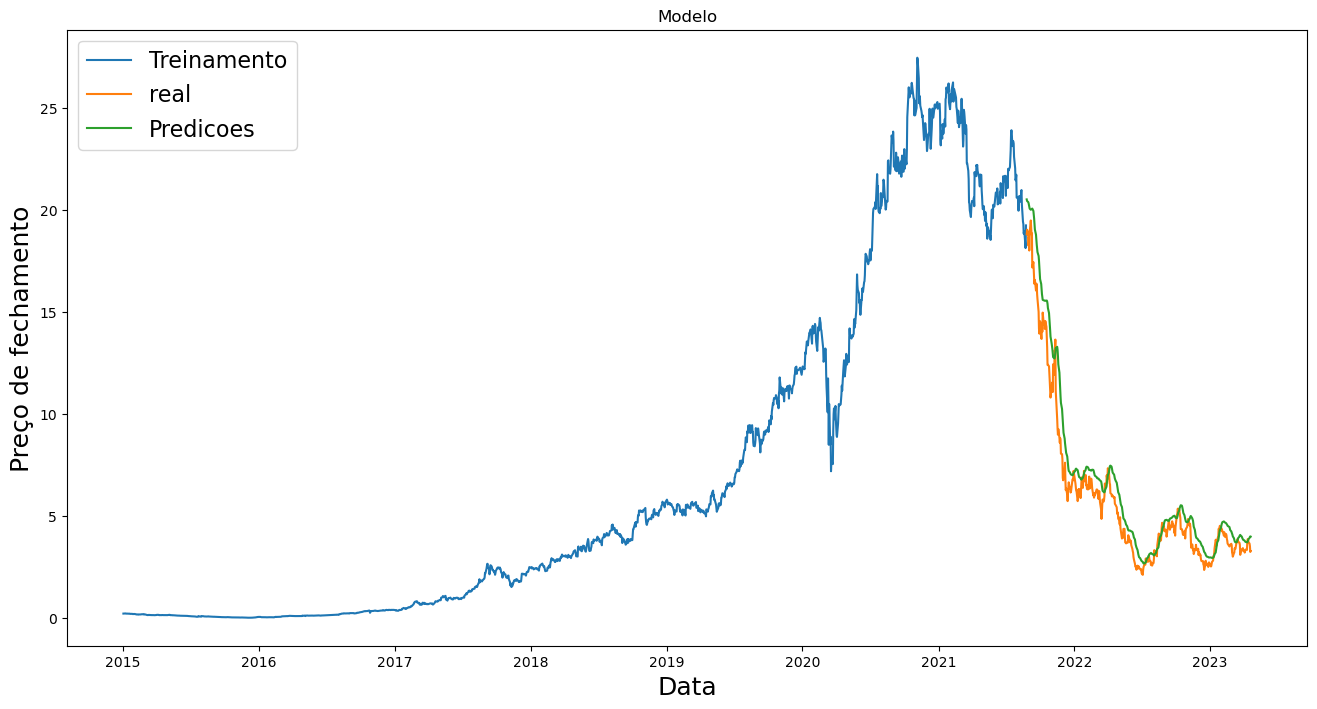

In [51]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Preço de fechamento', fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'Predicoes']])
plt.legend(['Treinamento', 'real', 'Predicoes'], loc = 2, prop={'size': 16})
plt.show()

In [52]:
df_teste.sort_index()

df_teste

,Close,Predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2021-08-26,18.799999,20.513567,-0.038363,-0.003490,False,False,True,0.038363
2021-08-27,19.030001,20.436214,0.012234,-0.003771,True,False,False,0.012234
2021-08-30,18.879999,20.383806,-0.007882,-0.002564,False,False,True,0.007882
2021-08-31,18.240000,20.336493,-0.033898,-0.002321,False,False,True,0.033898
2021-09-01,18.680000,20.245132,0.024123,-0.004492,True,False,False,0.024123
...,...,...,...,...,...,...,...,...
2023-04-14,3.740000,3.875050,-0.031088,0.017887,False,True,False,0.031088
2023-04-17,3.660000,3.937364,-0.021390,0.016081,False,True,False,0.021390
2023-04-18,3.540000,3.985607,-0.032787,0.012253,False,True,False,0.032787


In [53]:
#o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Sera q isso foi feito?

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['Predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, 
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, 
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

,Close,Predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2021-08-27,19.030001,20.436214,0.012234,-0.003771,True,False,False,0.012234
2021-08-30,18.879999,20.383806,-0.007882,-0.002564,False,False,True,0.007882
2021-08-31,18.240000,20.336493,-0.033898,-0.002321,False,False,True,0.033898
2021-09-01,18.680000,20.245132,0.024123,-0.004492,True,False,False,0.024123
2021-09-02,18.010000,20.172245,-0.035867,-0.003600,False,False,True,0.035867
...,...,...,...,...,...,...,...,...
2023-04-14,3.740000,3.875050,-0.031088,0.017887,False,True,False,0.031088
2023-04-17,3.660000,3.937364,-0.021390,0.016081,False,True,False,0.021390
2023-04-18,3.540000,3.985607,-0.032787,0.012253,False,True,False,0.032787


In [54]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

acertou_o_lado
False    0.040180
True     0.039177
Name: variacao_percentual_acao_abs, dtype: float64
0.9750492804184914
0.5109489051094891
0.03676176724090145


In [55]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    
#nao vai botar outra ação aqui hein kkkkkkkk
cotacoes = pdr.get_data_yahoo(acao, inicial, final) 
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 27ms/step
[[3.904921]]
